# 最尤推定

*MLE - Maximum Likelihood Estimation*

<br>

あるデータ$X$が得られた時、$Xの$尤度$p(X;\theta)$を最大化するパラメータ$\theta$を求める。  

$$
\argmax_{\theta} \, p(X;\theta)
$$

In [1]:
import torch
import pyro
import pyro.distributions as dist
import numpy as np
import matplotlib.pyplot as plt
import random


---

## 尤度

ある確率変数$x$の尤もらしさ。数学的に言うと、確率密度関数に$x$を代入して得られた値。確率密度関数は、確率変数がある範囲から得られる確率がその範囲の積分によって求められるような関数。

よく尤度のことをそのデータが得られる確率と言われるが、これは間違いな気がする。確率変数が離散値の場合は尤度=確率が成り立つけど連続値の場合は成り立たないかな？

また標本$X=\{ x_1, x_2, \cdots, x_i \}$が得られた時の尤度は以下のように表す。

$$
p(X;\theta) = \prod_{i=1}^{N} p(x_i;\theta)
$$


---

## 総当たりで求める

$\theta$の値を全て試して求める。

参考
- [最尤推定量とは？初めての人にもわかる解説 | AVILEN AI Trend](https://ai-trend.jp/basic-study/estimator/maximum-likelihood-estimation/)

<br>

以下の問題を例題として考える

> 箱の中に10個の玉がある。玉の色は赤か白のいずれかである。  
> 箱の中からランダムに玉を取り出し、色を確認してから戻す。これを10回繰り返した。  
> その結果、赤玉が3回、白玉が7回出てきた。さあ、箱の中には赤玉が何個あるだろうか。

箱の中身を直接覗くのはナシなので、一番確率の高い個数を求める問題となる。  
直感的に、この問題の答えを3個だと感じる人は多いだろう。実際にその感覚は正しくて、以下はそれを数学的に示す説明である。

では解いていく。

$x$を「赤が出た回数を表す確率変数」とすると、$x$は二項分布に従う。二項分布の確率密度関数は以下。  

$$
\mathrm{bin}(x; n, p) = {}_n C_x p^x (1-p)^{n-x}
$$


二項分布のパラメータは試行回数$n$と確率$p$で、今回の場合$n=10$が確定しており、$p$が推定したいパラメータとなる。この$p$は今後$\theta$と表記する。  
$\theta$は箱の中に入っている赤玉の割合を表す。正解の赤玉は3個なので、$\theta=\frac{3}{n}=0.3$が正解。

<br>

最尤推定ではまず尤度関数$L(\theta|x)$を設定する。これは、あるパラメータ$\theta$の下であるデータ$x$が得られる確率を返す、$\theta$についての関数である。$\theta$を変数として扱いたくて、$p(x;\theta)$だと$x$が変数っぽくなっちゃうから、逆にしたやつを考えただけ、みたいな認識でよい。  

$$
L(\theta|x) = p(x;\theta) = \mathrm{bin}(x; n, \theta) = {}_n C_x \theta^x (1-\theta)^{n-x}
$$

最尤推定で求めたいものは以下のように表せる。

$$
\argmax_{\theta} \, L(\theta;x)
$$

今回はこれを総当たりで求める。この問題において、$\theta$は以下の11通りである。

In [2]:
theta = torch.arange(0, 10 + 1) / 10
theta

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000])

これら一つ一つで尤度を計算して、最大値を取った$\theta$を求めるだけ。

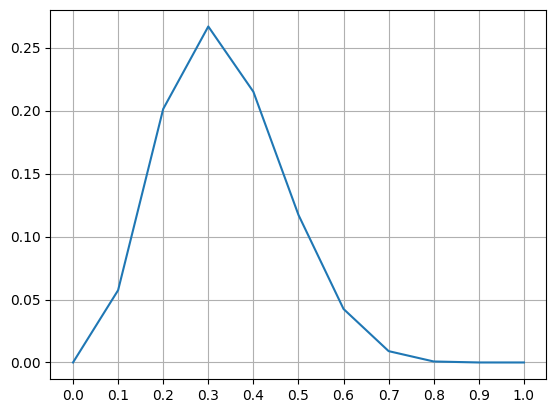

In [3]:
x = torch.tensor(3) # 実測値
n = 10 # 試行回数

binomal = dist.Binomial(n, theta) # 試行回数10, 確率psの二項分布
probs = binomal.log_prob(x).exp() # 分布から3が得られる確率
plt.plot(theta, probs)
plt.xticks(theta)
plt.grid();

$\theta = 0.3$が最も大きくなった。正解！これは**最尤推定量**と呼ぶ。  
以上より、箱の中には赤玉が$n \times \theta = 3$個あると推定できる。


---

## 解析的に求める

先ほどは$\theta$が離散値で且つ選択肢も少なかったので総当たりで求められたが、選択肢が多い場合やそもそも連続値の場合、総当たりには限界がある。  
そこで、解析的に（計算で）求める手法を考える。

やり方は簡単で、尤度関数を$\theta$について微分して、傾きが0になる$\theta$を求めるだけ。  
この時の尤度は正確には極大（小）値であるが、大体の場合は最大値を表している。最大値を表さない場合はこの手法を使えない（多分）。

またほとんどの場合、普通の尤度関数ではなく対数をとった**対数尤度関数**を考える。この方が計算しやすいから。$\log(x)$は単調増加関数で$\argmax_{\theta} p(X|\theta) = \argmax_{\theta} \log p(X|\theta)$が成り立つため、置き換えることが可能。

### 正規分布

正規分布を対象に解析的な最尤推定を行う。得られたデータを観察したら正規分布が適切だと感じ、正確なパラメータを求めたい、という場面。

正規分布のパラメータは平均$\mu$と分散$\sigma^2$で、これらを推定する訳だけど、これも直感的に考えたら、得られたデータの平均と分散がそのまま入りそうだなと思う。そしてそれも実際その通り。でもこれはあくまでも直感なので、ちゃんと数学的にも正しいことを証明していこう。

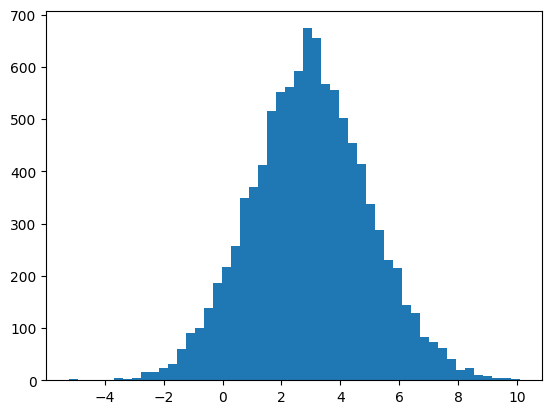

In [4]:
mu, sigma = 3, 2 # 平均3, 標準偏差2（分散4）

x = dist.Normal(mu, sigma).sample((10000,))
plt.hist(x, bins=50);

こんなデータが得られたとする。ちゃんと正規分布が仮定できそうなヒストグラムになった。  
では実際に求めていく。最初に書いた通り、対数尤度関数を最大にするパラメータを求める。↑の正解は$\mu=3, \sigma^2=4$。

まず適当に式変形していく。

$$
\begin{align}
\log L(\theta|X)
&= \log p(X;\theta) \\
&= \log \prod_{i=1}^n p(x_i;\theta) \\
&= \sum_{i=1}^n \log p(x_i;\theta) \\
&= \sum_{i=1}^n \log \left( \frac{1}{\sqrt{2\pi\sigma^2}} \exp \left( -\frac{(x_i-\mu)^2}{2\sigma^2} \right) \right) \\
\end{align}
$$

こんな風に、対数にすると積を和にできる。これは微分をする上でとってもありがたいこと。

では、これを各パラメータ（$\mu$、$\sigma^2$）について微分して、最適な値を求める。  
一旦、分かり易いように対数尤度関数を$g(\mu, \sigma^2)$と置いて、さらに式を変形する。

$$
\begin{align}
g(\mu, \sigma^2)
&= \sum_{i=1}^n \log \left( \frac{1}{\sqrt{2\pi\sigma^2}} \exp \left( -\frac{(x_i-\mu)^2}{2\sigma^2} \right) \right) \\
&= \sum_{i=1}^n \left( \log \left( \frac{1}{\sqrt{2\pi\sigma^2}} \right) + \log \left( \exp \left( -\frac{(x_i-\mu)^2}{2\sigma^2} \right) \right) \right) \\
&= \sum_{i=1}^n \left( -\frac{1}{2}\log(2\pi) - \log\sigma - \frac{(x_i-\mu)}{2\sigma^2} \right)
\end{align} \\
$$

ここから、微分していく

まずは$\mu$から。

$$
\begin{align}
\frac{\partial g}{\partial\mu}
&= \frac{\partial}{\partial\mu} \sum_{i=1}^n -\frac{(x_i-\mu)^2}{2\sigma^2} \\
&= -\sum_{i=1}^n \frac{x_i-\mu}{\sigma}
\end{align}
$$

これが0になる$\mu$を求める。

$$
\begin{align}
-\sum_{i=1}^n \frac{x_i-\mu}{\sigma} &= 0 \\
(x_1-\mu) + (x_2-\mu) + \cdots + (x_n-\mu) &= 0 \\
(x_1 + x_2 + \cdots + x_n) - n\mu &= 0 \\
\frac{(x_1 + x_2 + \cdots + x_n)}{n} &= \mu
\end{align}
$$

ということで、無事$X$の平均値になった。

では、今度は$\sigma^2$を求めていく。

$$
\begin{align}
\frac{\partial g}{\partial\sigma} &= -\sum_{i=1}^n \left( \frac{\partial}{\partial\sigma} \log\sigma + \frac{\partial}{\partial\sigma} \frac{(x_i-\mu)^2}{2\sigma^2} \right) \\
&= -\sum_{i=1}^n \left( \frac{1}{\sigma} - \frac{(x_i-\mu)^2}{\sigma^3} \right) \\
&= -\sum_{i=1}^n \left( \frac{\sigma^2 - (x_i-\mu)^2}{\sigma^3} \right)
\end{align}
$$

これが0になる$\sigma^2$を求める。

$$
\begin{align}
-\sum_{i=1}^n \left( \frac{\sigma^2 - (x_i-\mu)^2}{\sigma^3} \right) &= 0 \\
\sum_{i=1}^n (x_i-\mu)^2 &= n\sigma^2 \\
\frac{\sum_{i=1}^n (x_i-\mu)^2}{n} &= \sigma^2 \\
\end{align}
$$

ということで、無事$X$の分散になった。

実際に得られたデータで算出してみる

In [5]:
mu_hat = x.mean() # 平均
sigma_hat = x.std() # 標準偏差
print(f'mu: {mu_hat:.2f}, sigma: {sigma_hat:.2f}')

mu: 2.97, sigma: 2.00


正解の$\mu=3, \sigma=2$に近い値が求められた

### 二項分布

二項分布でもやってみる。さっきの例題を使う。

> 箱の中に10個の玉がある。玉の色は赤か白のいずれかである。  
> 箱の中からランダムに玉を取り出し、色を確認してから戻す。これを10回繰り返した。  
> その結果、赤玉が3回、白玉が7回出てきた。さあ、箱の中には赤玉が何個あるだろうか。

求め方はさっきと一緒で、対数尤度関数を微分して0になるパラメータを求める。

では求めていこう、の前に、この問題は1つのパラメータを求める問題なので、尤度関数を可視化できる。せっかくなので見てみよう。

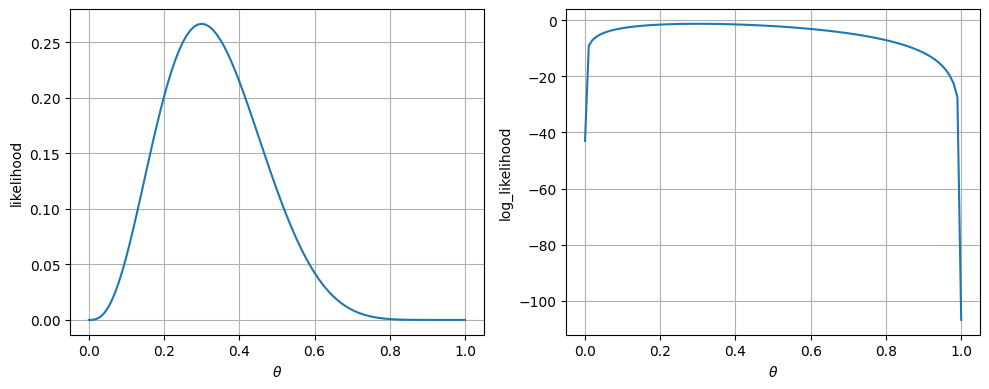

In [6]:
x = torch.tensor(3) # 実測値

p = torch.arange(0, 1 + 0.01, 0.01)
binomal = dist.Binomial(10, p)
log_likelihood = binomal.log_prob(x) # 対数尤度
likelihood = log_likelihood.exp() # 尤度
plt.figure(figsize=(10, 4))
for i, name in enumerate(['likelihood', 'log_likelihood']):
    plt.subplot(1, 2, i+1)
    plt.plot(p, eval(name))
    plt.xlabel(r'$\theta$')
    plt.ylabel(name)
    plt.grid()
plt.tight_layout();

ちゃんと上に凸な形になっていて、傾きが0になる唯一の$\theta$が最大値となっている。

では求めていこう。まずは対数尤度関数を変形する。

$$
\begin{align}
    \mathrm{log} \, L(\theta|x)
        &= \mathrm{log} \, \left( {}_n C_x \theta^x (1-\theta)^{n-x} \right) \\
        &= \mathrm{log} \, {}_n C_x + x \mathrm{log} \, \theta + (n-x) \mathrm{log} \, (1-\theta) \\ 
\end{align}
$$

次にこれを$\theta$で微分する

$$
\begin{align}
    \frac{\partial}{\partial\theta} \mathrm{log} \, L(\theta|x)
        &= 0 + \frac{x}{\theta} - \frac{n-x}{1-\theta} \\
        &= \frac{x(1-\theta) - (n-x)\theta}{\theta(1-\theta)} \\
        &= \frac{x - \theta n}{\theta(1-\theta)} \\
\end{align}
$$

でこれが0になる$\theta$を求める

$$
\begin{align}
    \frac{x - \theta n}{\theta(1-\theta)} &= 0 \\
    x - \theta n &= 0 \\
    \theta n &= x \\
    \theta &= \frac{x}{n} \\
\end{align}
$$

できた。  
$n=10, x=3$より、$\theta = \frac{3}{10} = 0.3$が最尤推定量となる。